In [ ]:

import pickle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from seqeval.metrics import classification_report
import matplotlib.pyplot as plt

In [16]:
data = []
with open("../dataset/dataset_ner_srl.tsv", encoding="utf-8") as f:
    tokens, ner_labels, srl_labels = [], [], []
    for line in f:
        line = line.strip()
        if not line:
            if tokens:
                data.append({
                    "tokens": tokens,
                    "labels_ner": ner_labels,
                    "labels_srl": srl_labels
                })
                tokens, ner_labels, srl_labels = [], [], []
        else:
            token, ner, srl = line.split("\t")
            tokens.append(token)
            ner_labels.append(ner)
            srl_labels.append(srl)

In [17]:

# 2. Preprocessing
sentences = [[tok.lower() for tok in item["tokens"]] for item in data]
labels_ner = [item["labels_ner"] for item in data]
labels_srl = [item["labels_srl"] for item in data]

words = sorted({w for s in sentences for w in s})
ner_tags = sorted({t for seq in labels_ner for t in seq})
srl_tags = sorted({t for seq in labels_srl for t in seq})

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["PAD"], word2idx["UNK"] = 0, 1

tag2idx_ner = {t: i for i, t in enumerate(ner_tags)}
tag2idx_srl = {t: i for i, t in enumerate(srl_tags)}
idx2tag_ner = {i: t for t, i in tag2idx_ner.items()}
idx2tag_srl = {i: t for t, i in tag2idx_srl.items()}

X = [[word2idx.get(w, word2idx["UNK"]) for w in s] for s in sentences]
y_ner = [[tag2idx_ner[t] for t in seq] for seq in labels_ner]
y_srl = [[tag2idx_srl[t] for t in seq] for seq in labels_srl]

maxlen = 50
X = pad_sequences(X, maxlen=maxlen, padding="post", value=word2idx["PAD"])
y_ner = pad_sequences(y_ner, maxlen=maxlen, padding="post", value=tag2idx_ner["O"])
y_srl = pad_sequences(y_srl, maxlen=maxlen, padding="post", value=tag2idx_srl["O"])

y_ner = to_categorical(y_ner, num_classes=len(tag2idx_ner))
y_srl = to_categorical(y_srl, num_classes=len(tag2idx_srl))

X_train, X_test, y_ner_train, y_ner_test, y_srl_train, y_srl_test = train_test_split(
    X, y_ner, y_srl, test_size=0.2, random_state=42, shuffle=True
)

In [18]:

# 3. Model
input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=len(word2idx), output_dim=64)(input_layer)
bilstm_layer = Bidirectional(LSTM(units=64, return_sequences=True))(embedding_layer)

ner_output = TimeDistributed(Dense(len(tag2idx_ner), activation="softmax"), name="ner_output")(bilstm_layer)
srl_output = TimeDistributed(Dense(len(tag2idx_srl), activation="softmax"), name="srl_output")(bilstm_layer)

model = Model(inputs=input_layer, outputs=[ner_output, srl_output])
model.compile(
    optimizer="adam",
    loss={
        "ner_output": "categorical_crossentropy",
        "srl_output": "categorical_crossentropy",
    },
    metrics={
        "ner_output": [tf.keras.metrics.CategoricalAccuracy(name="accuracy")],
        "srl_output": [tf.keras.metrics.CategoricalAccuracy(name="accuracy")],
    }
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 50, 64)    │     46,016 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 128)   │     66,048 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ner_output          │ (None, 50, 25)    │      3,225 │ bidirectional_2[… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ srl_output          │ (None, 50, 18)    │      2,322 │ bidirectional_2[… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 117,611 (459.42 KB)

 Trainable params: 117,611 (459.42 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(
    X_train,
    {"ner_output": y_ner_train, "srl_output": y_srl_train},
    validation_data=(X_test, {"ner_output": y_ner_test, "srl_output": y_srl_test}),
    batch_size=2,
    epochs=10,
    verbose=1
)

# 5. Save artifacts
model.save("multi_task_lstm_ner_srl_model_tf.keras")
with open("word2idx.pkl", "wb") as f:
    pickle.dump(word2idx, f)
with open("tag2idx_ner.pkl", "wb") as f:
    pickle.dump(tag2idx_ner, f)
with open("tag2idx_srl.pkl", "wb") as f:
    pickle.dump(tag2idx_srl, f)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 3.1783 - ner_output_accuracy: 0.8803 - ner_output_loss: 1.5415 - srl_output_accuracy: 0.7421 - srl_output_loss: 1.6365 - val_loss: 0.7449 - val_ner_output_accuracy: 0.9488 - val_ner_output_loss: 0.2727 - val_srl_output_accuracy: 0.8513 - val_srl_output_loss: 0.4722
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7761 - ner_output_accuracy: 0.9485 - ner_output_loss: 0.2537 - srl_output_accuracy: 0.8194 - srl_output_loss: 0.5225 - val_loss: 0.6895 - val_ner_output_accuracy: 0.9488 - val_ner_output_loss: 0.2616 - val_srl_output_accuracy: 0.8525 - val_srl_output_loss: 0.4279
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6680 - ner_output_accuracy: 0.9534 - ner_output_loss: 0.2254 - srl_output_accuracy: 0.8478 - srl_output_loss: 0.4425 - val_loss: 0.6540 - val_ner_output_accuracy: 0.9488 - val_ner_output_loss: 0.2505 - val_srl_output_accuracy: 0.8775 - val_srl_output_loss: 0.4036
Epoch 4/10
64/64 ━━━━━━━━

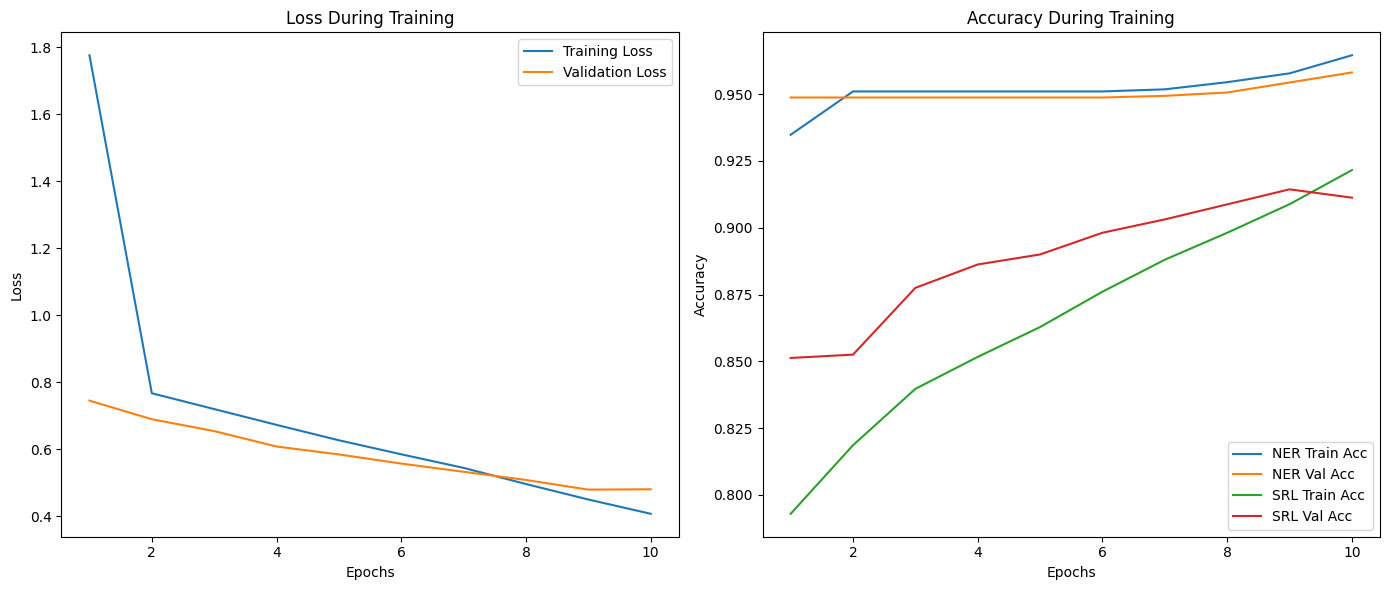

In [20]:

def plot_training_history(history):
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['ner_output_accuracy'], label='NER Train Acc')
    plt.plot(epochs, history['val_ner_output_accuracy'], label='NER Val Acc')
    plt.plot(epochs, history['srl_output_accuracy'], label='SRL Train Acc')
    plt.plot(epochs, history['val_srl_output_accuracy'], label='SRL Val Acc')
    plt.title('Accuracy During Training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
plot_training_history(history.history)


In [21]:
def token_level_accuracy(y_true, y_pred):
    total, correct = 0, 0
    for true_seq, pred_seq in zip(y_true, y_pred):
        for t, p in zip(true_seq, pred_seq):
            if t.sum() == 0:
                continue
            total += 1
            if t.argmax() == p.argmax():
                correct += 1
    return correct / total

def decode_predictions(pred, true, idx2tag):
    true_out, pred_out = [], []
    for pred_seq, true_seq in zip(pred, true):
        t_labels, p_labels = [], []
        for p_tok, t_tok in zip(pred_seq, true_seq):
            if t_tok.sum() == 0:
                continue
            t_labels.append(idx2tag[t_tok.argmax()])
            p_labels.append(idx2tag[p_tok.argmax()])
        true_out.append(t_labels)
        pred_out.append(p_labels)
    return true_out, pred_out

results = model.evaluate(X_test, {"ner_output": y_ner_test, "srl_output": y_srl_test}, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

y_pred_ner, y_pred_srl = model.predict(X_test, verbose=0)

true_ner, pred_ner = decode_predictions(y_pred_ner, y_ner_test, idx2tag_ner)
true_srl, pred_srl = decode_predictions(y_pred_srl, y_srl_test, idx2tag_srl)

acc_ner = token_level_accuracy(y_ner_test, y_pred_ner)
acc_srl = token_level_accuracy(y_srl_test, y_pred_srl)

print(f"NER Token Accuracy {acc_ner:.2%}")
print(f"SRL Token Accuracy {acc_srl:.2%}")



loss: 0.48032140731811523
compile_metrics: 0.18580493330955505
ner_output_loss: 0.2945164740085602
srl_output_loss: 0.9581250548362732
NER Token Accuracy 95.81%
SRL Token Accuracy 91.12%


In [22]:
print("[NER] Classification Report:")
print(classification_report(true_ner, pred_ner, digits=2))

[NER] Classification Report:
              precision    recall  f1-score   support

        DATE       0.80      0.36      0.50        11
       EVENT       0.00      0.00      0.00         1
         LOC       1.00      0.38      0.55        21
         MIN       0.00      0.00      0.00         3
        MISC       0.00      0.00      0.00         1
         ORG       0.00      0.00      0.00         3
         PER       0.00      0.00      0.00         2
         RES       0.00      0.00      0.00         2
        TIME       0.33      0.38      0.35         8

   micro avg       0.68      0.29      0.41        52
   macro avg       0.24      0.12      0.16        52
weighted avg       0.62      0.29      0.38        52



/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
print("SRL Classification Resport:")
print(classification_report(true_srl, pred_srl, digits=2))

SRL Classification Resport:
              precision    recall  f1-score   support

         FRQ       0.00      0.00      0.00         1
         LOC       0.27      0.43      0.33         7
         MNR       0.00      0.00      0.00         3
         PRP       0.00      0.00      0.00         1
         RG0       0.38      0.18      0.24        17
         RG1       0.23      0.21      0.22        47
         RG2       0.18      0.27      0.21        11
         RG3       0.00      0.00      0.00         3
         TMP       0.55      0.61      0.58        18
           _       0.40      0.12      0.19        33

   micro avg       0.31      0.24      0.27       141
   macro avg       0.20      0.18      0.18       141
weighted avg       0.31      0.24      0.25       141



/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: V seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARGM-TMP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/